## PROYECTO FINAL MASTER DE BIG DATA & BUSINESS ANALYTICS
MODELO NO SUPERVISADO DE CLUSTERIZACIÓN
PARA UNA APLICACION DE ENCONTRAR COMPAÑEROS DE PISO

**En este cuaderno vamos a realizar la creación de un modelo no supervisado de Clusterización, en el que realizamos el preprocesamiento, análisis exploratorio, pruebas con diferentes modelos, aplicamos técnicas como k-means y realizamos visualizaciones.**

In [ ]:
# Importamos los paquetes necesarios para realizar el proyecto
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kstest
from scipy.stats import spearmanr
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

In [ ]:
# Importamos el dataset
from google.colab import drive
drive.mount('/content/drive')
cuestionario = pd.read_excel ("/content/drive/MyDrive/cuestionario_completo.xlsx")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Conectamos SQLite con Python
import sqlite3
conn = sqlite3.connect("cuestionario_respuestas.db")
cuestionario.to_sql("respuestas", conn, if_exists="replace", index=False)

226

In [ ]:
# Comprobamos que se haya conectado correctamente
query = "SELECT * FROM respuestas"
cuestionario_sql = pd.read_sql_query(query, conn)
print(cuestionario_sql.head())

               Marca temporal  \
0  2024-12-19 12:35:33.075000   
1  2024-12-19 13:42:19.738000   
2  2024-12-19 17:45:18.500000   
3  2024-12-19 17:46:20.392000   
4  2024-12-19 17:47:36.514000   

  ¿Cuál es la renta que estarías dispuesto/a a pagar por tu parte del alquiler?  \
0                                           300-450€                              
1                                           300-450€                              
2                                           300-450€                              
3                                           200-300€                              
4                                           200-300€                              

   ¿Cuántos años tienes? (en formato numérico)  Género  \
0                                         22.0  Hombre   
1                                         22.0   Mujer   
2                                         22.0  Hombre   
3                                         53.0   Mujer   
4           

In [ ]:
# Comprobamos que el dataset (el de excel) se haya importado bien y
# observamos el tipo de variables que tiene, los nulos, etc.
cuestionario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 27 columns):
 #   Column                                                                                                                                         Non-Null Count  Dtype         
---  ------                                                                                                                                         --------------  -----         
 0   Marca temporal                                                                                                                                 226 non-null    datetime64[ns]
 1   ¿Cuál es la renta que estarías dispuesto/a a pagar por tu parte del alquiler?                                                                  224 non-null    object        
 2   ¿Cuántos años tienes? (en formato numérico)                                                                                                    224 non-null    float64       


In [ ]:
# Cambiamos el nombre de las columnas, que guardaban el nombre de las preguntas
# del cuestionario.
# Vamos a poner nombres con los que sea facil trabajar con ellas.


# Dada la naturaleza del cuestionario, tenemos que borrar previamente espacios
# y saltos de linea para que se pueda aplicar bien el diccionario.
cuestionario.columns = cuestionario.columns.str.strip()


# Diccionario con los nuevos nombres
columnas_renombradas = {
    "Marca temporal": "marca_temporal",
    "¿Cuál es la renta que estarías dispuesto/a a pagar por tu parte del alquiler?": "renta_maxima",
    "¿Cuántos años tienes? (en formato numérico)": "edad",
    "Género": "genero",
    "Has compartido piso alguna vez": "compartido_piso",
    "¿Qué tan importante es para ti la limpieza en el piso?": "limpieza_importancia",
    "¿Cuáles son tus hábitos de limpieza?": "limpieza_habitos",
    "¿Cómo prefieres gestionar las tareas del hogar?": "limpieza_organizacion_tareas",
    "¿Qué nivel de silencio quieres en el hogar?\n** 5 = Ruidos ocasionales como música, televisión, conversaciones": "ruido_dia",
    "¿Qué expectativas tienes sobre el nivel de ruido durante la noche (horario de descanso)?\n** 5 = Ruido como TV o videos a bajo volumen": "ruido_noche",
    "¿Fumas?": "fumas",
    "¿Te importa que otras personas fumen dentro del piso?": "fumar_otras_personas",
    "¿Prefieres una vida comunitaria o más aislada dentro del piso?": "vida_comunitaria",
    "¿Qué uso te gustaría darle a los espacios comunes del piso?": "espacios_comunes",
    "¿Cuántas personas te gustaría que fuerais en el piso?": "num_personas",
    "¿Te gustaría que vinieran invitados al piso?": "invitados",
    "¿Qué opinas sobre las mascotas en el piso?": "mascotas",
    "¿Qué tipo de música escuchas con mayor frecuencia?": "musica",
    "¿Practicas algún deporte?": "deporte",
    "¿Te interesa el cine y las series?": "cine",
    "¿Lees libros habitualmente?": "lectura",
    "¿Te gusta cocinar?": "cocina",
    "¿Qué nivel de interacción social te gustaría tener con tus compañeros de piso en actividades como ver deporte, cine, jugar videojuegos, etc.?": "interaccion_social",
    "¿Quieres un ambiente LGBT+ friendly en el piso?": "lgbt_friendly",
    "¿Te gustaría organizar o participar en fiestas/previas en el piso ?": "fiestas",
    "¿Qué tipo de horario llevas entre semana?": "horario_semana",
    "Durante el fin de semana, ¿cómo prefieres organizar tus días?": "horario_fin_semana"
}

# Renombramos las columnas en el DataFrame original
cuestionario.rename(columns=columnas_renombradas, inplace=True)

# Verificamos que se hayan cambiado bien
print(cuestionario.columns)

Index(['marca_temporal', 'renta_maxima', 'edad', 'genero', 'compartido_piso',
       'limpieza_importancia', 'limpieza_habitos',
       'limpieza_organizacion_tareas', 'ruido_dia', 'ruido_noche', 'fumas',
       'fumar_otras_personas', 'vida_comunitaria', 'espacios_comunes',
       'num_personas', 'invitados', 'mascotas', 'musica', 'deporte', 'cine',
       'lectura', 'cocina', 'interaccion_social', 'lgbt_friendly', 'fiestas',
       'horario_semana', 'horario_fin_semana'],
      dtype='object')


In [ ]:
# Comprobamos el dataset
cuestionario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   marca_temporal                226 non-null    datetime64[ns]
 1   renta_maxima                  224 non-null    object        
 2   edad                          224 non-null    float64       
 3   genero                        225 non-null    object        
 4   compartido_piso               224 non-null    object        
 5   limpieza_importancia          225 non-null    float64       
 6   limpieza_habitos              225 non-null    object        
 7   limpieza_organizacion_tareas  224 non-null    object        
 8   ruido_dia                     225 non-null    float64       
 9   ruido_noche                   225 non-null    float64       
 10  fumas                         224 non-null    object        
 11  fumar_otras_personas          22

In [ ]:
# Eliminamos la columna de la marca temporal, que no aporta nada por ser valor
# unico
cuestionario = cuestionario.drop(columns=["marca_temporal"])

In [ ]:
# Hacemos un pequeño cambio en la variable de Horario Fin de Semana fruto de
# un cambio que hice entre que realice yo el cuestionario y lo distribuí.
respuestas_unicas = cuestionario["horario_fin_semana"].unique()
print(respuestas_unicas)

['Prefiero descansar' 'Prefiero descansar e ir viendo qué hago'
 'Me gusta madrugar para aprovecharlos'
 'Los fines de semana soy de horario más nocturno' nan
 'No sabe/No contesta']


In [ ]:
# Ejecutamos el reemplazo de una respuesta por otra
cuestionario["horario_fin_semana"] = cuestionario["horario_fin_semana"].replace("Prefiero descansar", "Prefiero descansar e ir viendo qué hago")

In [ ]:
print(cuestionario["horario_fin_semana"].unique())

['Prefiero descansar e ir viendo qué hago'
 'Me gusta madrugar para aprovecharlos'
 'Los fines de semana soy de horario más nocturno' nan
 'No sabe/No contesta']


In [ ]:
# Vemos los nulos de cada columna
cuestionario.isnull().sum()

,0
renta_maxima,2
edad,2
genero,1
compartido_piso,2
limpieza_importancia,1
limpieza_habitos,1
limpieza_organizacion_tareas,2
ruido_dia,1
ruido_noche,1
fumas,2


In [ ]:
# Vemos la fila del nulo en una de las variables que solo tienen un nulo,
# ya que es extraño que todas las variables tengan nulos
nulos_genero = cuestionario["genero"].isnull()
cuestionario[nulos_genero]

,renta_maxima,edad,genero,compartido_piso,limpieza_importancia,limpieza_habitos,limpieza_organizacion_tareas,ruido_dia,ruido_noche,fumas,...,musica,deporte,cine,lectura,cocina,interaccion_social,lgbt_friendly,fiestas,horario_semana,horario_fin_semana
27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Quitamos ese registro, asi tenemos un dataset mucho mas limpio de nulos
generos = cuestionario["genero"].notnull()
cuestionario = cuestionario [generos]

In [ ]:
# Comprobamos cómo ha quedado
cuestionario.isnull().sum()

,0
renta_maxima,1
edad,1
genero,0
compartido_piso,1
limpieza_importancia,0
limpieza_habitos,0
limpieza_organizacion_tareas,1
ruido_dia,0
ruido_noche,0
fumas,1


In [ ]:
# Ahora debemos quitar el resto de nulos. Hay 2 opciones:
# - Eliminar todos los registros en los que haya nulos
# - Rellenar los nulos: en las variables numéricas con la media o mediana
#   y en las categoricas con la moda
# Dado que no tenemos una muestra muy grande, es mejor la segunda opción

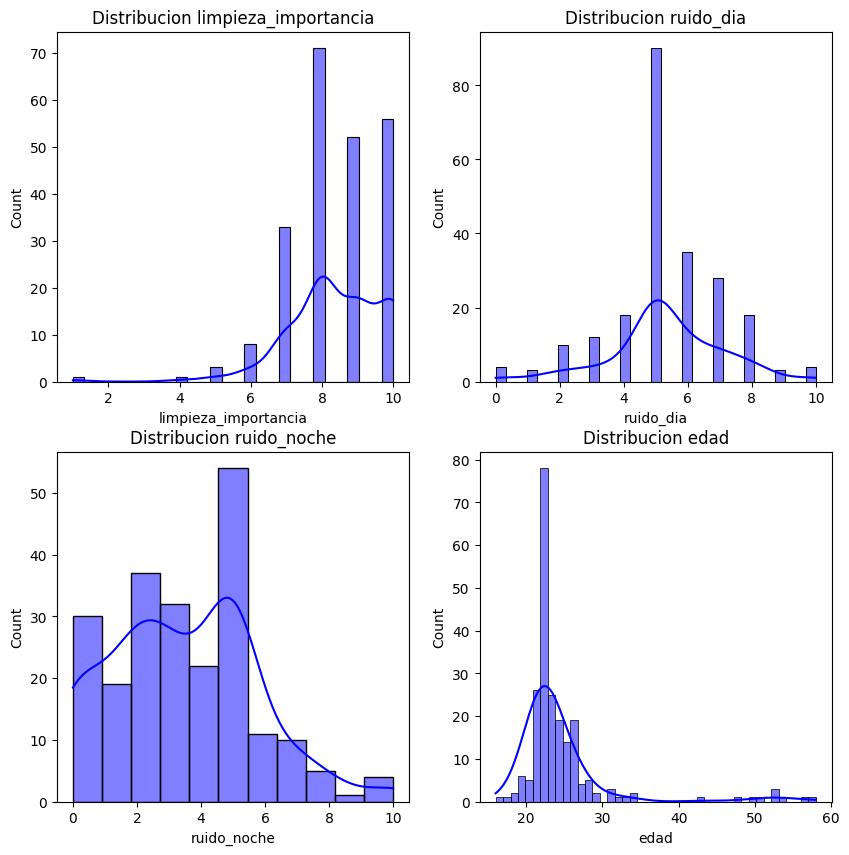

In [ ]:
# Vamos a observar la distribución de las variables numericas del DataFrame.
# Para ello, las juntamos todas en una y luego realizamos un gráfico donde nos
# salgan las 4 variables.

variables_numericas = cuestionario[["limpieza_importancia", "ruido_dia", "ruido_noche", "edad"]]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axes = ax.flatten()
for i, col in enumerate(variables_numericas.columns):
    sns.histplot(variables_numericas[col], kde=True, ax=axes[i], color='blue')
    axes[i].set_title(f'Distribucion {col}')

<ipython-input-648-7b8fb9c9f175>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cuestionario["edad"], shade=True, color="darkorange")


Text(0, 0.5, 'Densidad')

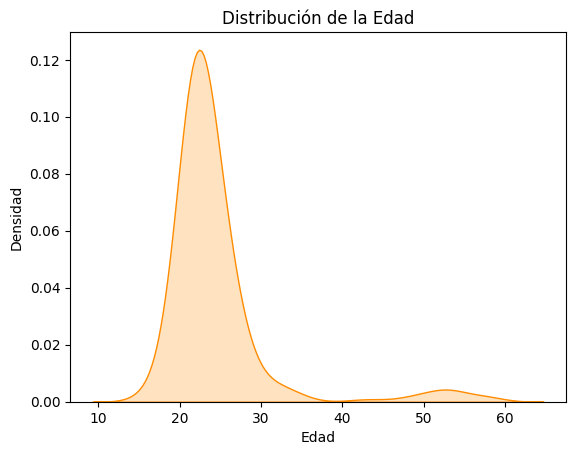

In [ ]:
# Comenzamos con la edad, la única variable numérica
# Vamos a ver más especificamente como se distribuye
# Comprobamos si la edad sigue una distrubucion normal
sns.kdeplot(cuestionario["edad"], shade=True, color="darkorange")
plt.title("Distribución de la Edad")
plt.xlabel("Edad")
plt.ylabel("Densidad")

In [ ]:
# Por cómo se distribuye, es mejor usar la mediana (22 años) que la media
mediana = cuestionario["edad"].median()
cuestionario["edad"].fillna(mediana, inplace=True)

<ipython-input-649-f117b6b70f8b>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cuestionario["edad"].fillna(mediana, inplace=True)


In [ ]:
# Verificamos
cuestionario["edad"].isnull().sum()

0

In [ ]:
# Ahora vamos con las categoricas, antes de comenzar, hay que tener en cuenta que
# en el cuestionario se daba la opción de No sabe/No contesta.
# Como  esta respuesta carece de importancia, son muy pocas las respuestas asi,
# están repartidas en varias varibles y no nos interesa en el DataFrame,
# vamos a pasar los valores a nulos y le vamos a imputar la moda

cuestionario.replace("No sabe/No contesta", np.nan, inplace=True)

In [ ]:
# Comenzamos con la variable de si han compartido piso alguna vez
moda_compartido_piso = cuestionario["compartido_piso"].mode()[0]
cuestionario ["compartido_piso"] = cuestionario ["compartido_piso"].fillna(moda_compartido_piso)

In [ ]:
# Comprobamos que se haya hecho bien
cuestionario["compartido_piso"].isnull().sum()

0

In [ ]:
# Repetimos proceso con el resto de variables categóricas con nulos
moda_renta_maxima = cuestionario["renta_maxima"].mode()[0]
cuestionario ["renta_maxima"] = cuestionario ["renta_maxima"].fillna(moda_renta_maxima)
moda_limpieza_organizacion_tareas = cuestionario["limpieza_organizacion_tareas"].mode()[0]
cuestionario ["limpieza_organizacion_tareas"] = cuestionario ["limpieza_organizacion_tareas"].fillna(moda_limpieza_organizacion_tareas)
moda_fumas = cuestionario["fumas"].mode()[0]
cuestionario ["fumas"] = cuestionario ["fumas"].fillna(moda_fumas)
moda_fumar_otras_personas = cuestionario["fumar_otras_personas"].mode()[0]
cuestionario ["fumar_otras_personas"] = cuestionario ["fumar_otras_personas"].fillna(moda_fumar_otras_personas)
moda_mascotas = cuestionario["mascotas"].mode()[0]
cuestionario ["mascotas"] = cuestionario ["mascotas"].fillna(moda_mascotas)
moda_lectura = cuestionario["lectura"].mode()[0]
cuestionario ["lectura"] = cuestionario ["lectura"].fillna(moda_lectura)
moda_deporte = cuestionario["deporte"].mode()[0]
cuestionario ["deporte"] = cuestionario ["deporte"].fillna(moda_deporte)
moda_cocina = cuestionario["cocina"].mode()[0]
cuestionario ["cocina"] = cuestionario ["cocina"].fillna(moda_cocina)
moda_lgbt_friendly = cuestionario["lgbt_friendly"].mode()[0]
cuestionario ["lgbt_friendly"] = cuestionario ["lgbt_friendly"].fillna(moda_lgbt_friendly)
moda_fiestas = cuestionario["fiestas"].mode()[0]
cuestionario ["fiestas"] = cuestionario ["fiestas"].fillna(moda_fiestas)
moda_horario_semana = cuestionario["horario_semana"].mode()[0]
cuestionario ["horario_semana"] = cuestionario ["horario_semana"].fillna(moda_horario_semana)
moda_horario_fin_semana = cuestionario["horario_fin_semana"].mode()[0]
cuestionario ["horario_fin_semana"] = cuestionario ["horario_fin_semana"].fillna(moda_horario_fin_semana)

In [ ]:
# Comprobamos y vemos que el DataFrame ha quedado sin nulos
cuestionario.isnull().sum()

,0
renta_maxima,0
edad,0
genero,0
compartido_piso,0
limpieza_importancia,0
limpieza_habitos,0
limpieza_organizacion_tareas,0
ruido_dia,0
ruido_noche,0
fumas,0


In [ ]:
# Vemos los estadisticos descriptivos básicos de las numéricas
print(cuestionario["edad"].describe())
print(cuestionario["ruido_dia"].describe())
print(cuestionario["ruido_noche"].describe())

count    225.000000
mean      24.417778
std        6.583505
min       16.000000
25%       22.000000
50%       22.000000
75%       25.000000
max       58.000000
Name: edad, dtype: float64
count    225.000000
mean       5.324444
std        1.814273
min        0.000000
25%        5.000000
50%        5.000000
75%        6.000000
max       10.000000
Name: ruido_dia, dtype: float64
count    225.000000
mean       3.431111
std        2.309899
min        0.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       10.000000
Name: ruido_noche, dtype: float64


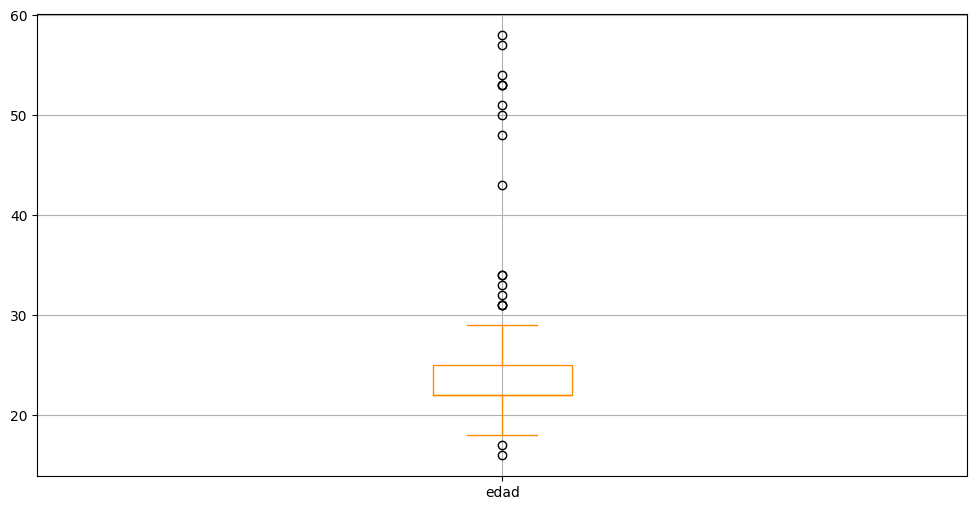

In [ ]:
# De nuestro DataFrame, la única variable que necesita limpieza de outliers es
# la edad, por lo que vamos iniciar el procedimiento
cuestionario['edad'].plot(kind='box', color='darkorange', figsize=(12, 6), grid=True);

In [ ]:
# Procedemos a hacer limpieza de outliers a través del metodo de IQR
Q1 = cuestionario["edad"].quantile(0.25)
Q3 = cuestionario["edad"].quantile(0.75)
IQR = Q3 - Q1

# Usamos los limites estándar
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Antes de eliminarlos identificamos cuántos valores están fuera de los límites
# para saber cuantos vamos a perder, en caso de ser muchos podriamos estudiar
# otros métodos
outliers = cuestionario[(cuestionario["edad"] < limite_inferior) | (cuestionario["edad"] > limite_superior)]
num_outliers = len(outliers)
print(num_outliers)

19


Como es una app más centrada en personas jóvenes y la mayoría de outliers pertenecen al limite superior, podemos prescindir de ellos sin que suponga una pérdida de información muy significativa

In [ ]:
# Generamos el nuevo DataFrame sin los outliers
cuestionario = cuestionario[(cuestionario["edad"] >= limite_inferior) & (cuestionario["edad"] <= limite_superior)]

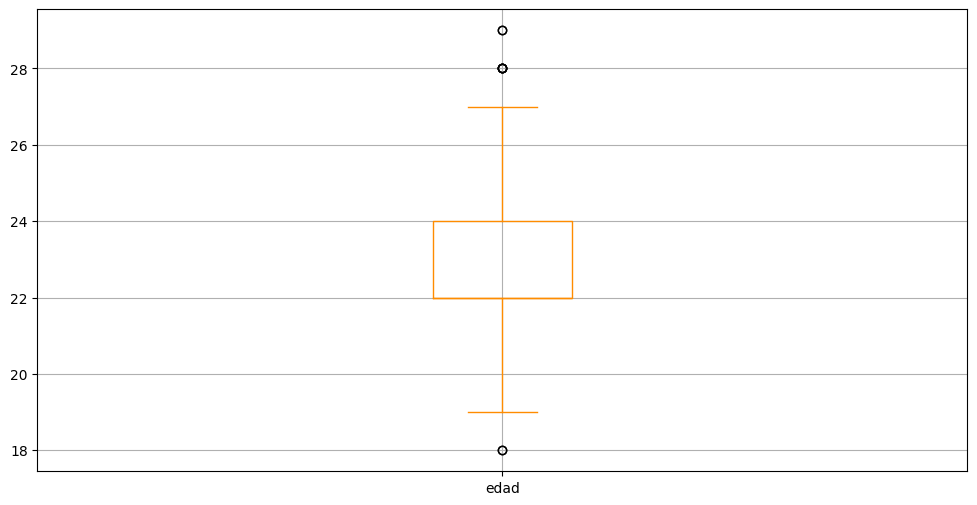

In [ ]:
# Vemos como es el BoxPlot ahora
cuestionario['edad'].plot(kind='box', color='darkorange', figsize=(12, 6), grid=True);

In [ ]:
# Vemos cómo ha quedado la variable edad
cuestionario["edad"].describe()

,edad
count,206.000000
mean,22.888350
std,2.070032
min,18.000000
25%,22.000000
50%,22.000000
75%,24.000000
max,29.000000


<ipython-input-662-0b5730b6fbbd>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cuestionario["edad"], shade=True, color="darkorange")


Text(0, 0.5, 'Densidad')

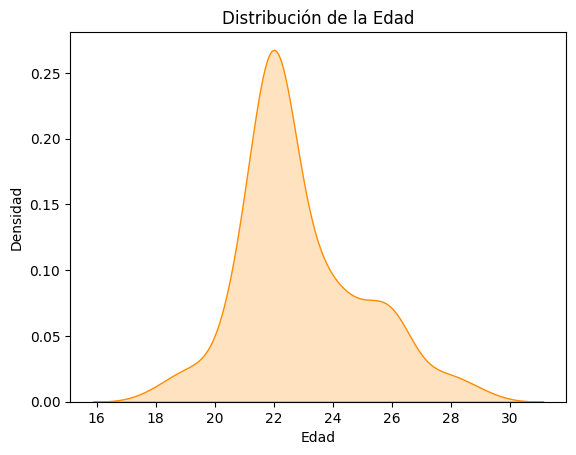

In [ ]:
sns.kdeplot(cuestionario["edad"], shade=True, color="darkorange")
plt.title("Distribución de la Edad")
plt.xlabel("Edad")
plt.ylabel("Densidad")

In [ ]:
# Realizamos prueba de Normalidad a través del test de Kolmogorov-Smirnov para
# saber si ahora es normal o no
stat, p = kstest(cuestionario["edad"], 'norm')
print(f"Estadístico: {stat}, p-valor: {p}")

if p > 0.05:
    print("No se rechaza H₀: Los datos siguen una distribución normal.")
else:
    print("Se rechaza H₀: Los datos no siguen una distribución normal.")

Estadístico: 1.0, p-valor: 0.0
Se rechaza H₀: Los datos no siguen una distribución normal.


Aquí ya vemos que la distribución de la edad se asemeja mucho más a la normalidad, aunque sin llegar a serla. Esta distribución se debe a las propias características de quienes han ayudado a compartir el cuestionario (personas de 22 años y una persona de 26). Como vemos hay una gran densidad de respuestas de 22 años y luego hay un pequeño aumento en los 26 años. Sin embargo, podriamos afirmar que la limpieza de outliers realizada ha sido efectiva. Se han perdido un total de 19 casos, a partir de ahora tenemos n = 204.

In [ ]:
# Normalizamos entre 0 y 1 la edad para que no tenga más peso en el modelo
cuestionario["edad_scaled"]=(cuestionario["edad"]- cuestionario["edad"].min())/ (cuestionario["edad"].min()-cuestionario["edad"].max()) *-1
cuestionario["edad_scaled"].describe()

,edad_scaled
count,206.000000
mean,0.444395
std,0.188185
min,0.000000
25%,0.363636
50%,0.363636
75%,0.545455
max,1.000000


In [ ]:
# Realizamos el mismo proceso con el resto de variables numéricas
# En estas variables no hay que hacer limpieza de outliers ya que son respuestas
# que van de 1 al 10, si limpiamos estariamos perdiendo informacion importante
cuestionario["ruido_dia_scaled"]=(cuestionario["ruido_dia"]- cuestionario["ruido_dia"].min())/ (cuestionario["ruido_dia"].min()-cuestionario["ruido_dia"].max()) *-1
cuestionario["ruido_dia_scaled"].describe()

,ruido_dia_scaled
count,206.000000
mean,0.537864
std,0.181923
min,0.000000
25%,0.500000
50%,0.500000
75%,0.600000
max,1.000000


In [ ]:
cuestionario["ruido_noche_scaled"]=(cuestionario["ruido_noche"]- cuestionario["ruido_noche"].min())/ (cuestionario["ruido_noche"].min()-cuestionario["ruido_noche"].max()) *-1
cuestionario["ruido_noche_scaled"].describe()

,ruido_noche_scaled
count,206.000000
mean,0.352427
std,0.232838
min,0.000000
25%,0.200000
50%,0.300000
75%,0.500000
max,1.000000


In [ ]:
cuestionario["limpieza_importancia_scaled"]=(cuestionario["limpieza_importancia"]- cuestionario["limpieza_importancia"].min())/ (cuestionario["limpieza_importancia"].min()-cuestionario["limpieza_importancia"].max()) *-1
cuestionario["limpieza_importancia_scaled"].describe()

,limpieza_importancia_scaled
count,206.000000
mean,0.824703
std,0.147703
min,0.000000
25%,0.777778
50%,0.777778
75%,0.888889
max,1.000000


In [ ]:
# Una vez finalizado el tratamiento de columnas numericas
# ahora vamos a tratar la columna de num_personas, su tratamiento es algo
# especial, ya que combina texto con números y es una columna multirespuesta,
# por lo que no podemos hacer un simple get dummies
cuestionario["num_personas"].unique()

array([3, 4, '3, 4', 2, '2, 3', '2, 3, 4', '2, 3, 4, Más de 4',
       '3, 4, Más de 4', '4, Más de 4', 'Más de 4'], dtype=object)

In [ ]:
# Primero tenemos que limpiar el texto
# Reemplazamos "Más de 4" por un número, como por ejemplo el 5
# Luego eliminamos espacios en blanco
cuestionario["num_personas"] = cuestionario["num_personas"].astype(str).str.replace("Más de 4", "5")
cuestionario["num_personas"] = cuestionario["num_personas"].str.replace(" ", "")

# Dividimos las combinaciones en columnas binarias, pero no de 1 columna por cada
# combinación de respuesta ya que tenemos registros con 2 respuestas o más
dummies = cuestionario["num_personas"].str.get_dummies(sep=",")

# Lo metemos en el DataFrame original
cuestionario = pd.concat([cuestionario, dummies], axis=1)

In [ ]:
# Tratamos la variable genero, primero vemos sus valores, ya que podría haber
# mas de 2
print(cuestionario["genero"].unique())
print(cuestionario["genero"].dtype)

['Hombre' 'Mujer']
object


In [ ]:
# Como aparece como object la cambiamos a string; aplicamos get dummies
cuestionario["genero"] = cuestionario["genero"].astype(str)
cuestionario = pd.get_dummies (cuestionario, columns= ["genero"], drop_first=True)

In [ ]:
# Comprobamos
cuestionario.head()

,renta_maxima,edad,compartido_piso,limpieza_importancia,limpieza_habitos,limpieza_organizacion_tareas,ruido_dia,ruido_noche,fumas,fumar_otras_personas,...,horario_fin_semana,edad_scaled,ruido_dia_scaled,ruido_noche_scaled,limpieza_importancia_scaled,2,3,4,5,genero_Mujer
0,300-450€,22.0,Si,8.0,Limpio regularmente y una vez a la semana me g...,Lo vamos organizando sobre la marcha según lo ...,4.0,1.0,Solo en ocasiones especiales,Solo si es ocasionalmente y sin olor permananente,...,Prefiero descansar e ir viendo qué hago,0.363636,0.4,0.1,0.777778,0,1,0,0,False
1,300-450€,22.0,No,9.0,Limpio regularmente y una vez a la semana me g...,Prefiero que haya un reparto claro y equitativ...,5.0,1.0,No,Solo si es ocasionalmente y sin olor permananente,...,Prefiero descansar e ir viendo qué hago,0.363636,0.5,0.1,0.888889,0,1,0,0,True
2,300-450€,22.0,No,9.0,Limpio cuando se ensucia algo,Prefiero que haya un reparto claro y equitativ...,6.0,6.0,No,Solo si es ocasionalmente y sin olor permananente,...,Me gusta madrugar para aprovecharlos,0.363636,0.6,0.6,0.888889,0,1,0,0,False
4,200-300€,25.0,No,10.0,Limpio regularmente y una vez a la semana me g...,Prefiero que haya un reparto claro y equitativ...,5.0,4.0,Si,Solo si es ocasionalmente y sin olor permananente,...,Me gusta madrugar para aprovecharlos,0.636364,0.5,0.4,1.000000,0,1,0,0,False
5,200-300€,22.0,No,6.0,Limpio cuando veo que la suciedad es alta,"No me gusta preocuparme por las tareas, prefie...",5.0,2.0,Si,No,...,Prefiero descansar e ir viendo qué hago,0.363636,0.5,0.2,0.555556,0,0,1,0,False


In [ ]:
# Como sigue devolviendo True o False y queremos formato numérico, lo forzamos
# pasandola a integer
cuestionario["genero_Mujer"] = cuestionario["genero_Mujer"].astype(int)

In [ ]:
# Comprobamos
cuestionario.head()

,renta_maxima,edad,compartido_piso,limpieza_importancia,limpieza_habitos,limpieza_organizacion_tareas,ruido_dia,ruido_noche,fumas,fumar_otras_personas,...,horario_fin_semana,edad_scaled,ruido_dia_scaled,ruido_noche_scaled,limpieza_importancia_scaled,2,3,4,5,genero_Mujer
0,300-450€,22.0,Si,8.0,Limpio regularmente y una vez a la semana me g...,Lo vamos organizando sobre la marcha según lo ...,4.0,1.0,Solo en ocasiones especiales,Solo si es ocasionalmente y sin olor permananente,...,Prefiero descansar e ir viendo qué hago,0.363636,0.4,0.1,0.777778,0,1,0,0,0
1,300-450€,22.0,No,9.0,Limpio regularmente y una vez a la semana me g...,Prefiero que haya un reparto claro y equitativ...,5.0,1.0,No,Solo si es ocasionalmente y sin olor permananente,...,Prefiero descansar e ir viendo qué hago,0.363636,0.5,0.1,0.888889,0,1,0,0,1
2,300-450€,22.0,No,9.0,Limpio cuando se ensucia algo,Prefiero que haya un reparto claro y equitativ...,6.0,6.0,No,Solo si es ocasionalmente y sin olor permananente,...,Me gusta madrugar para aprovecharlos,0.363636,0.6,0.6,0.888889,0,1,0,0,0
4,200-300€,25.0,No,10.0,Limpio regularmente y una vez a la semana me g...,Prefiero que haya un reparto claro y equitativ...,5.0,4.0,Si,Solo si es ocasionalmente y sin olor permananente,...,Me gusta madrugar para aprovecharlos,0.636364,0.5,0.4,1.000000,0,1,0,0,0
5,200-300€,22.0,No,6.0,Limpio cuando veo que la suciedad es alta,"No me gusta preocuparme por las tareas, prefie...",5.0,2.0,Si,No,...,Prefiero descansar e ir viendo qué hago,0.363636,0.5,0.2,0.555556,0,0,1,0,0


In [ ]:
# Así tenemos el DataFrame en esta fase del tratamiento de datos
cuestionario.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206 entries, 0 to 225
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   renta_maxima                  206 non-null    object 
 1   edad                          206 non-null    float64
 2   compartido_piso               206 non-null    object 
 3   limpieza_importancia          206 non-null    float64
 4   limpieza_habitos              206 non-null    object 
 5   limpieza_organizacion_tareas  206 non-null    object 
 6   ruido_dia                     206 non-null    float64
 7   ruido_noche                   206 non-null    float64
 8   fumas                         206 non-null    object 
 9   fumar_otras_personas          206 non-null    object 
 10  vida_comunitaria              206 non-null    object 
 11  espacios_comunes              206 non-null    object 
 12  num_personas                  206 non-null    object 
 13  invitados 

In [ ]:
# Hacemos con la musica el mismo proceso que hemos hecho con el genero
print(cuestionario["musica"].unique())
print(cuestionario["musica"].dtype)

['Urbano' 'Escucho de todo' 'Reggaeton' 'Indie' 'Rap' 'Otros' 'Pop']
object


In [ ]:
# Como aparece como object la cambiamos a string; aplicamos get dummies
cuestionario["musica"] = cuestionario["musica"].astype(str)
cuestionario = pd.get_dummies (cuestionario, columns= ["musica"], drop_first=True)

In [ ]:
# Como sigue devolviendo True o False y queremos formato numérico, lo forzamos
# pasandola a integer
cuestionario["musica_Indie"] = cuestionario["musica_Indie"].astype(int)
cuestionario["musica_Otros"] = cuestionario["musica_Otros"].astype(int)
cuestionario["musica_Pop"] = cuestionario["musica_Pop"].astype(int)
cuestionario["musica_Rap"] = cuestionario["musica_Rap"].astype(int)
cuestionario["musica_Urbano"] = cuestionario["musica_Urbano"].astype(int)
cuestionario["musica_Reggaeton"] = cuestionario["musica_Reggaeton"].astype(int)

In [ ]:
# Como el resto de columnas son ordinales, vamos a asignarles un valor que vaya
# entre 0 y 1. No hay que hacer OHE con ellas, asi evitamos tener mucha
# dimensionalidad y asignamos valores de 0 a 1 en un mismo proceso

In [ ]:
# Vamos a asignar los valores mediante un diccionario mapeado
valores_numericos = {
    "renta_maxima": {
        "Menos de 200€": 0.0,
        "200-300€": 0.25,
        "300-450€": 0.5,
        "450-600€": 0.75,
        "Más de 600€": 1.0
    },
    "compartido_piso": {
        "Si": 1.0,
        "No": 0.0
    },
    "limpieza_habitos": {
        "Limpio cuando veo que la suciedad es alta": 0.0,
        "Limpio cuando se ensucia algo": 0.33,
        "Limpio regularmente y una vez a la semana me gusta hacer limpieza de piso": 0.66,
        "Limpio mucho todos los días": 1.0
    },
    "limpieza_organizacion_tareas": {
        "No me gusta preocuparme por las tareas, prefiero que sea algo espontáneo": 0.0,
        "Lo vamos organizando sobre la marcha según lo que vaya surgiendo": 0.33,
        "Prefiero que haya un reparto claro y equitativo de las tareas": 0.66
    },
    "fumas": {
        "Si": 1.0,
        "Solo en ocasiones especiales": 0.5,
        "No": 0.0
    },
    "fumar_otras_personas": {
        "No": 0.0,
        "Solo si es ocasionalmente y sin olor permananente": 0.5,
        "Si": 1.0
    },
    "vida_comunitaria": {
        "Totalmente comunitaria (compartir tiempo y actividades)": 1.0,
        "Moderadamente comunitaria (algunas actividades compartidas)": 0.66,
        "Independiente, pero con buena convivencia": 0.33,
        "Prefiero una vida totalmente aislada": 0.0
    },
    "espacios_comunes": {
        "Me gustaría usarlos con frecuencia para actividades como comer, socializar o relajarme": 1.0,
        "Usarlos de vez en cuando, solo para actividades puntuales.": 0.5,
        "Prefiero quedarme en mi habitación y apenas uso los espacios comunes.": 0.0
    },
    "invitados": {
        "Sí, no me importaría que haya invitados": 1.0,
        "Solo en ocasiones especiales": 0.5,
        "Prefiero que no vengan invitados al piso": 0.0
    },
    "mascotas": {
        "Me parecen bien las mascotas en el piso": 1.0,
        "Puede ser, todo es hablarlo": 0.5,
        "Prefiero que no haya mascotas en el piso": 0.0
    },
    "deporte": {
        "Sí, de manera regular": 1.0,
        "Sí, pero solo ocasionalmente": 0.66,
        "No, pero me interesaría empezar alguno": 0.33,
        "No, no me gusta el deporte": 0.0
    },
    "cine": {
        "Me encanta, siempre estoy viendo algo": 1.0,
        "Sí, pero de vez en cuando": 0.66,
        "Solo cuando alguien más las sugiere": 0.33,
        "No, no me interesa": 0.0
    },
    "lectura": {
        "Si, regularmente": 1.0,
        "Solo cuando tengo tiempo libre": 0.66,
        "Muy raramente": 0.33,
        "No leo libros": 0.0
    },
    "cocina": {
        "Si, lo disfruto mucho": 1.0,
        "Solo lo necesario": 0.5,
        "Prefiero no cocinar": 0.0
    },
    "interaccion_social": {
        "Alto, hacer estas actividades juntos de forma habitual": 1.0,
        "Un equilibrio, a veces participar en actividades con mis compañeros, pero también tener mi espacio personal": 0.5,
        "Prefiero mi propio espacio y suelo ser más independiente, participando en actividades solo ocasionalmente": 0.0
    },
    "lgbt_friendly": {
        "Si": 1.0,
        "Me es indiferente": 0.5,
        "No": 0.0
    },
    "fiestas": {
        "Sí, frecuentemente": 1.0,
        "Si surge bien": 0.5,
        "No me interesa": 0.0
    },
    "horario_semana": {
        "Soy nocturno (Levantarse de 11:30 en adelante)": 0.0,
        "Horario intermedio (Levantarse entre las 8:30 y las 11:30)": 0.5,
        "Madrugo mucho (Levantarse antes de las 8:30)": 1.0
    },
    "horario_fin_semana": {
        "Me gusta madrugar para aprovecharlos": 1.0,
        "Prefiero descansar e ir viendo qué hago": 0.5,
        "Los fines de semana soy de horario más nocturno": 0.0
    }
}

# Lo aplicamos con bucle for
for columna, valores_numericos in valores_numericos.items():
    cuestionario[columna] = cuestionario[columna].map(valores_numericos)

In [ ]:
# Comprobamos
cuestionario.head()

,renta_maxima,edad,compartido_piso,limpieza_importancia,limpieza_habitos,limpieza_organizacion_tareas,ruido_dia,ruido_noche,fumas,fumar_otras_personas,...,3,4,5,genero_Mujer,musica_Indie,musica_Otros,musica_Pop,musica_Rap,musica_Reggaeton,musica_Urbano
0,0.50,22.0,1.0,8.0,0.66,0.33,4.0,1.0,0.5,0.5,...,1,0,0,0,0,0,0,0,0,1
1,0.50,22.0,0.0,9.0,0.66,0.66,5.0,1.0,0.0,0.5,...,1,0,0,1,0,0,0,0,0,0
2,0.50,22.0,0.0,9.0,0.33,0.66,6.0,6.0,0.0,0.5,...,1,0,0,0,0,0,0,0,0,0
4,0.25,25.0,0.0,10.0,0.66,0.66,5.0,4.0,1.0,0.5,...,1,0,0,0,0,0,0,0,0,0
5,0.25,22.0,0.0,6.0,0.00,0.00,5.0,2.0,1.0,0.0,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
# Droppeamos las columnas que hemos escalado
cuestionario = cuestionario.drop(columns=["edad", "ruido_dia", "ruido_noche", "limpieza_importancia", "num_personas"])

In [ ]:
# Ya tenemos todo el preprocesamiento realizado, ahora comprobamos que esté
# correcto y que todas las variables estén entre 0 y 1
cuestionario.head(20)

,renta_maxima,compartido_piso,limpieza_habitos,limpieza_organizacion_tareas,fumas,fumar_otras_personas,vida_comunitaria,espacios_comunes,invitados,mascotas,...,3,4,5,genero_Mujer,musica_Indie,musica_Otros,musica_Pop,musica_Rap,musica_Reggaeton,musica_Urbano
0,0.50,1.0,0.66,0.33,0.5,0.5,1.00,1.0,0.5,0.5,...,1,0,0,0,0,0,0,0,0,1
1,0.50,0.0,0.66,0.66,0.0,0.5,1.00,1.0,1.0,1.0,...,1,0,0,1,0,0,0,0,0,0
2,0.50,0.0,0.33,0.66,0.0,0.5,0.66,0.5,0.5,1.0,...,1,0,0,0,0,0,0,0,0,0
4,0.25,0.0,0.66,0.66,1.0,0.5,1.00,1.0,1.0,0.5,...,1,0,0,0,0,0,0,0,0,0
5,0.25,0.0,0.00,0.00,1.0,0.0,0.66,1.0,1.0,0.5,...,0,1,0,0,0,0,0,0,0,0
6,0.50,0.0,0.66,0.33,0.5,0.5,1.00,1.0,0.5,1.0,...,1,1,0,0,0,0,0,0,0,0
7,0.25,0.0,0.33,0.33,1.0,0.0,0.33,0.5,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
8,0.25,0.0,0.66,0.33,1.0,0.0,0.66,1.0,1.0,0.0,...,1,0,0,0,0,0,0,0,1,0
9,0.75,0.0,0.66,0.33,0.0,1.0,0.66,1.0,1.0,0.5,...,0,0,0,0,0,0,0,0,0,0
10,0.25,1.0,1.00,0.66,1.0,0.0,0.33,1.0,1.0,0.0,...,1,0,0,0,0,0,0,0,0,0


Con la realización del cuestionario, mas tarde me di cuenta que la pregunta acerca del ruido por la noche y día podía dar a malentendidos ya que estaba formulada de forma diferente:¿Qué nivel de silencio quieres en el hogar? (0 Silencio Total; 10 Ruido Constante), ¿Qué expectativas tienes sobre el nivel de ruido durante la noche (horario de descanso)?  (0 Silencio Total; 10 Ruido Constante). Es por ello que, para solucionar la duda de si las personas lo han entendido correctamente o no, vamos a observar una correlación entre las respuestas, si esta correlación es positiva y significativa quiere decir que efectivamente se ha contestado correctamente, si es negativa y significativa quiere decir que no se ha contestado correctamente y tendremos que aplicar otras tecnicas.

Text(0.5, 1.0, 'Relación entre ruido diurno y nocturno')

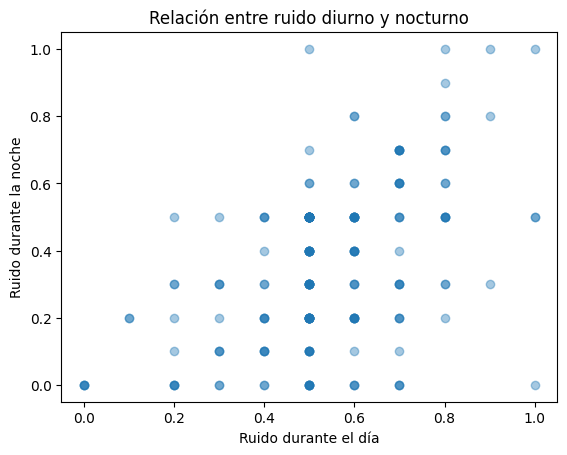

In [ ]:
# Observamos la relacion de estas variables mediante un gráfico de dispersión
plt.scatter(cuestionario["ruido_dia_scaled"], cuestionario["ruido_noche_scaled"], alpha=0.4)
plt.xlabel("Ruido durante el día")
plt.ylabel("Ruido durante la noche")
plt.title("Relación entre ruido diurno y nocturno")

In [ ]:
# Para asegurarnos, vamos a usar el estadistico de la Correlacion de Spearman
corr, p_value = spearmanr(cuestionario["ruido_dia_scaled"], cuestionario["ruido_noche_scaled"])
print(f"Correlación de Spearman: {corr}, p-valor: {p_value}")

Correlación de Spearman: 0.45875077608669884, p-valor: 4.074085054204761e-12


In [ ]:
# Vemos la correlación entre la edad y las fiestas
corr, p_value = spearmanr(cuestionario["edad_scaled"], cuestionario["fiestas"])
print(f"Correlación de Spearman: {corr}, p-valor: {p_value}")

Correlación de Spearman: -0.12929222993164557, p-valor: 0.06399962096835328


Vemos que hay cierta correlación, pero esta es muy debil, es negativa, lo que quiere decir que a mayor edad menor intención de que se monten fiestas en el piso, sin embargo no es significativa, su p-valor está por encima de 0.05, por lo que no podemos afirmar de forma consistente este relación. Además, por el corto rango de ambas variables (la edad se mueve los 18 y los 29 años, las fiestas en tan solo 3 valores) no podemos sacar conclusiones al respecto. También que existiera una variable de si es estudiante o trabajador ayudaría, en teoría los estudiantes salen mas de fiesta que los trabajadores, por lo que las fiestas en el piso sería mayor.

In [ ]:
# Vemos la correlación entre la edad y la renta, podriamos presuponer que a mayor
# edad, mayor renta está dispuesto a pagar por el alquiler
corr, p_value = spearmanr(cuestionario["edad_scaled"], cuestionario["renta_maxima"])
print(f"Correlación de Spearman: {corr}, p-valor: {p_value}")

Correlación de Spearman: -0.025031919352633422, p-valor: 0.7209829399632242


Tampoco es nada significativa, el gran problema de tratar de calcular esta correlación es que en el cuestionario no se ha incluido una pregunta sobre la ciudad en la que se reside, lo que hubiera sido muy útil para calcular la correlación de estás 3 variables, controlando por una de ellas y asi evitar relaciones espurias.

In [ ]:
# Vamos a ver la posible correlación entre el género y la preferencia por un
# ambiente ltbt friendly
corr, p_value = spearmanr(cuestionario["genero_Mujer"], cuestionario["lgbt_friendly"])
print(f"Correlación de Spearman: {corr}, p-valor: {p_value}")

Correlación de Spearman: 0.3757816082481074, p-valor: 2.6063807891539915e-08


Hay una asociación positiva y significativa entre el género y la preferencia por un ambiente LGBT+ friendly. Este resultado sugiere que el género influye en la preferencia por este tipo de ambiente, con una tendencia mayor entre las mujeres.

In [ ]:
corr, p_value = spearmanr(cuestionario["fumas"], cuestionario["fumar_otras_personas"])
print(f"Correlación de Spearman: {corr}, p-valor: {p_value}")

Correlación de Spearman: -0.4842981912860247, p-valor: 1.63934818259406e-13


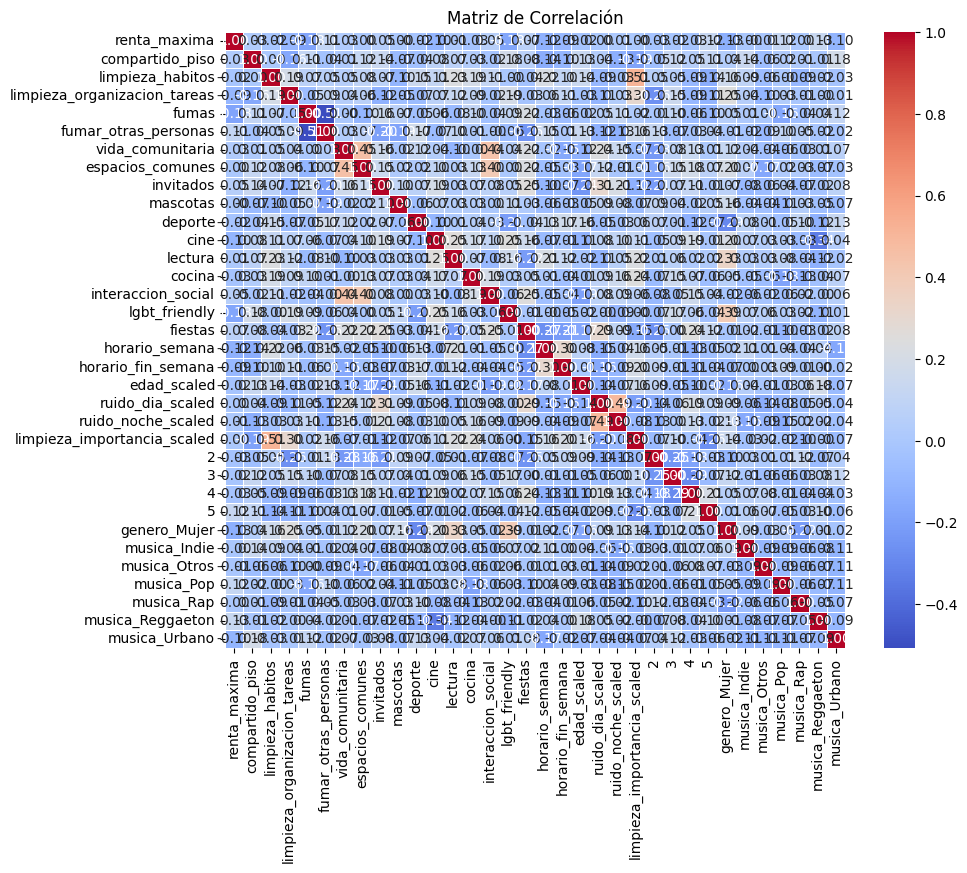

In [ ]:
# Calculamos la matriz de correlación, con la que vemos todas las correlaciones
# en vez de variable por variable
matriz_corr = cuestionario.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

In [ ]:
# Comenzamos con el Machine Learning
# Aplicamos K-Means antes de aplicar PCA para ver cómo sale, vamos a poner todo
# para que se haga con todas las variables del cuestionario y vamos a poner
# un rango elevado de clusters para elegir el mejor
X = cuestionario
rango_n_clusters = range(2, 11)
siluetas = []

In [ ]:
# Para ver cómo sale cada cluster, en vez de ir probando uno a uno, realizamos
# un bucle for para el rango que antes hemos fijado. Vamos a usar el indice de
# silueta para saber cuán bueno es el cluster.
for n_clusters in rango_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silueta_promedio = silhouette_score(X, cluster_labels)
    siluetas.append(silueta_promedio)
    print(f"Para {n_clusters} clústeres, el índice de silueta promedio es {silueta_promedio:.3f}")

Para 2 clústeres, el índice de silueta promedio es 0.100
Para 3 clústeres, el índice de silueta promedio es 0.094
Para 4 clústeres, el índice de silueta promedio es 0.077
Para 5 clústeres, el índice de silueta promedio es 0.077
Para 6 clústeres, el índice de silueta promedio es 0.060
Para 7 clústeres, el índice de silueta promedio es 0.074
Para 8 clústeres, el índice de silueta promedio es 0.072
Para 9 clústeres, el índice de silueta promedio es 0.071
Para 10 clústeres, el índice de silueta promedio es 0.070


Como vemos, el indice de Silueta es tremendamente bajo, a partir de 0.3 se puede considerar utilizable y a partir de 0.5 como bueno, por lo que menos de  0.1 es un resultado muy malo. Vamos a ver qué varianzas tiene nuestro modelo porque si son muy bajas es normal que salga asi

In [ ]:
# Calculamos la varianza de cada variable del cuestionario. Es muy baja
varianzas = cuestionario.var()
print(varianzas.sort_values())

limpieza_importancia_scaled     0.021816
5                               0.023798
musica_Rap                      0.032986
ruido_dia_scaled                0.033096
limpieza_organizacion_tareas    0.034926
edad_scaled                     0.035414
limpieza_habitos                0.038470
renta_maxima                    0.041671
vida_comunitaria                0.048432
espacios_comunes                0.053688
ruido_noche_scaled              0.054214
musica_Reggaeton                0.055127
interaccion_social              0.055180
cine                            0.063171
invitados                       0.070359
musica_Otros                    0.076083
musica_Pop                      0.076083
musica_Indie                    0.080133
fiestas                         0.081228
horario_semana                  0.087023
cocina                          0.088119
lgbt_friendly                   0.094062
horario_fin_semana              0.095596
deporte                         0.101250
musica_Urbano   

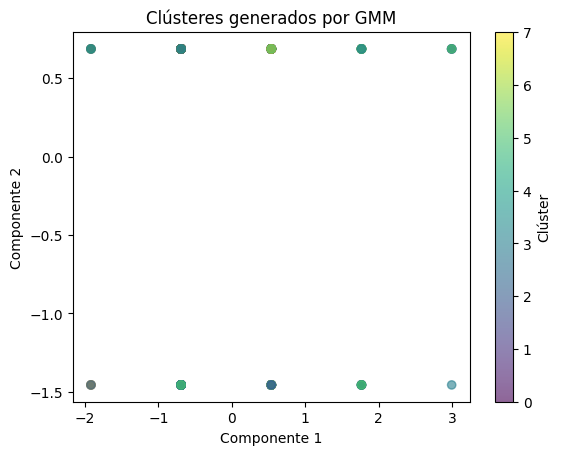

Log-Likelihood: 24.409192689317297
BIC: 16790.580626531973


In [ ]:
# Realizamos metodos alternativos a K-Means, dado que no ha dado resultado,
# vamos a comenzar con Gaussian Mixture (Para la realización de este código
# me ayude de ChatGPT ya que no entendía cómo realizarlo)

X = cuestionario
# Número de clústeres
n_clusters = 8  # Cambia según el número deseado
# Escalado de las variables
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Ajustar el modelo GMM
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm.fit(X)

# Predecir las etiquetas de los clústeres
labels = gmm.predict(X)

# Agregar las etiquetas de los clústeres al DataFrame
cuestionario['cluster'] = labels

# Visualización simple (si tienes 2 componentes principales)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.title("Clústeres generados por GMM")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.colorbar(label="Clúster")
plt.show()
# Log-Likelihood del modelo
print("Log-Likelihood:", gmm.score(X))

# BIC (criterio de información bayesiano)
print("BIC:", gmm.bic(X))



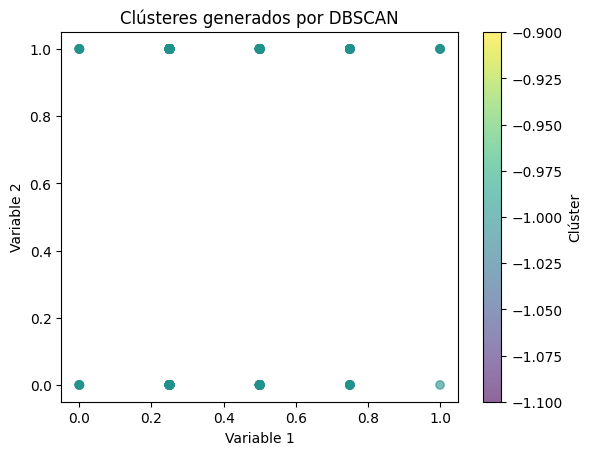

In [ ]:
# Aplicmos otra técnica, en este caso DBSCAN (Gráfico realizado con ayuda
# de ChatGPT ya que no conseguía que me saliera correctamente)
dbscan = DBSCAN(eps=0.3, min_samples=5)
labels = dbscan.fit_predict(cuestionario)
cuestionario['cluster'] = labels

# Gráfico
plt.scatter(cuestionario.iloc[:, 0], cuestionario.iloc[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.title("Clústeres generados por DBSCAN")
plt.xlabel("Variable 1")
plt.ylabel("Variable 2")
plt.colorbar(label="Clúster")
plt.show()


In [ ]:
# Como no hemos conseguido nada con estos modelos, vamos a aplicar PCA, con
# objetivo de capturar la maxima varianza con la menor cantidad de dimensiones
n_componentes = 7
pca = PCA(n_components=n_componentes)
X_pca = pca.fit_transform(cuestionario)

In [ ]:
print("Varianza explicada por cada componente:")
print(pca.explained_variance_ratio_)

print("Varianza acumulada:")
print(pca.explained_variance_ratio_.cumsum())

Varianza explicada por cada componente:
[0.11883895 0.09120212 0.08193414 0.07439258 0.07131961 0.04726249
 0.04626525]
Varianza acumulada:
[0.11883895 0.21004107 0.29197521 0.36636779 0.43768741 0.48494989
 0.53121514]


In [ ]:
# Nuestra varianza acumulada es muy baja, solo de 0.53, es decir, solo estamos
# cogiendo el 53% de la información para nuestro modelo. Como vemos, estamos
# teniendo un problema con la varianza del cuestionario.

In [ ]:
# Aplicamos k-means sobre los datos transformados por PCA
X = X_pca
rango_n_clusters = range(2, 11)
siluetas = []

for n_clusters in rango_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silueta_promedio = silhouette_score(X, cluster_labels)
    siluetas.append(silueta_promedio)
    print(f"Para {n_clusters} clústeres, el índice de silueta promedio es {silueta_promedio:.3f}")

Para 2 clústeres, el índice de silueta promedio es 0.154
Para 3 clústeres, el índice de silueta promedio es 0.180
Para 4 clústeres, el índice de silueta promedio es 0.172
Para 5 clústeres, el índice de silueta promedio es 0.160
Para 6 clústeres, el índice de silueta promedio es 0.179
Para 7 clústeres, el índice de silueta promedio es 0.191
Para 8 clústeres, el índice de silueta promedio es 0.186
Para 9 clústeres, el índice de silueta promedio es 0.178
Para 10 clústeres, el índice de silueta promedio es 0.176


In [ ]:
# Hemos mejorado el indice de silueta, sin embargo sigue muy por debajo de los
# umbrales que nos permitirían considerarlo como válido. Vamos a probar a tratar
# aumentar su varianza para que el modelo sea mejor.

In [ ]:
# Eliminamos las variables con una varianza muy baja
baja_varianza = [col for col in cuestionario.var().index if cuestionario[col].var() < 0.07]
cuestionario = cuestionario.drop(columns=baja_varianza)
print(f"Columnas eliminadas por baja varianza: {baja_varianza}")

Columnas eliminadas por baja varianza: ['renta_maxima', 'limpieza_habitos', 'limpieza_organizacion_tareas', 'vida_comunitaria', 'espacios_comunes', 'cine', 'interaccion_social', 'edad_scaled', 'ruido_dia_scaled', 'ruido_noche_scaled', 'limpieza_importancia_scaled', '5', 'musica_Rap', 'musica_Reggaeton', 'cluster']


In [ ]:
varianzas = cuestionario.var()
print(varianzas.sort_values())

invitados               0.070359
musica_Otros            0.076083
musica_Pop              0.076083
musica_Indie            0.080133
fiestas                 0.081228
horario_semana          0.087023
cocina                  0.088119
lgbt_friendly           0.094062
horario_fin_semana      0.095596
deporte                 0.101250
musica_Urbano           0.103434
lectura                 0.117685
mascotas                0.134555
fumas                   0.145442
fumar_otras_personas    0.147768
3                       0.168790
4                       0.184703
2                       0.205375
compartido_piso         0.218802
genero_Mujer            0.245892
dtype: float64


In [ ]:
# Como vemos, las variables que estamos eliminando eran a priori muy importantes
# para nuestro modelo, ya que son piezas clave de la convivencia (ruido,
# limpieza, renta, sociabilidad de las personas), sin embargo esta baja varianza
# se explica porque la gente ha respondido de una forma muy similar a estas
# preguntas. Por lo que, para este dataset daría igual eliminarlas ya que ya son
# similares en eso.

In [ ]:
# Aplicamos otra vez PCA pero esta vez sin estas variables con baja varianza
n_componentes = 7
pca = PCA(n_components=n_componentes)
X_pca = pca.fit_transform(cuestionario)

In [ ]:
print("Varianza explicada por cada componente:")
print(pca.explained_variance_ratio_)

print("Varianza acumulada:")
print(pca.explained_variance_ratio_.cumsum())

Varianza explicada por cada componente:
[0.13843067 0.10879466 0.09743792 0.08912279 0.08431256 0.05464953
 0.04972252]
Varianza acumulada:
[0.13843067 0.24722533 0.34466325 0.43378605 0.51809861 0.57274814
 0.62247066]


In [ ]:
# Hemos mejorado en algo la varianza acumulada, ha sido efectiva la eliminación
# de variables, sin embargo sigue estando por debajo de unos umbrales válidos.

In [ ]:
# Realizamos el mismo código que hemos hecho antes pero con los cambios
X = X_pca
rango_n_clusters = range(2, 11)
siluetas = []

for n_clusters in rango_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silueta_promedio = silhouette_score(X, cluster_labels)
    siluetas.append(silueta_promedio)
    print(f"Para {n_clusters} clústeres, el índice de silueta promedio es {silueta_promedio:.3f}")

Para 2 clústeres, el índice de silueta promedio es 0.153
Para 3 clústeres, el índice de silueta promedio es 0.186
Para 4 clústeres, el índice de silueta promedio es 0.182
Para 5 clústeres, el índice de silueta promedio es 0.182
Para 6 clústeres, el índice de silueta promedio es 0.192
Para 7 clústeres, el índice de silueta promedio es 0.181
Para 8 clústeres, el índice de silueta promedio es 0.187
Para 9 clústeres, el índice de silueta promedio es 0.190
Para 10 clústeres, el índice de silueta promedio es 0.163


In [ ]:
# Se ha mejorado algo la clusterización pero sigue siendo muy pobre, vamos a
# probar con alguna técnica más.

In [ ]:
# Vamos a probar aplicando rotación ortogonal en el PCA (realizado con ChatGPT
# ya que intente aplicarla por mí mismo y no lo conseguí)

!pip install factor-analyzer
from factor_analyzer import FactorAnalyzer

# Convertir las componentes a DataFrame
componentes_df = pd.DataFrame(X_pca)

# Aplicar rotación ortogonal (por ejemplo, Varimax)
fa = FactorAnalyzer(n_factors=n_componentes, rotation="varimax", method="principal")
fa.fit(cuestionario)

# Transformar las componentes con la rotación
X_pca_rotado = fa.transform(cuestionario)

# Mostrar las componentes rotadas
print("Componentes principales después de la rotación:")
print(X_pca_rotado)

Componentes principales después de la rotación:
[[-0.23425454 -0.75798906  0.21049531 ... -0.05630243 -0.10076605
   0.25236313]
 [ 0.45443541  1.31218722 -0.13139532 ...  0.04167102 -1.34512818
   1.00085463]
 [-0.13494787 -0.97703662  0.0922612  ...  1.15311615 -1.16632356
   1.10126917]
 ...
 [ 0.39468537 -0.06059302  1.35784695 ...  0.09680417 -0.52249947
  -0.34889164]
 [ 1.15692398  0.76496743 -1.41961794 ...  0.02916303 -0.79709035
  -1.1988469 ]
 [ 1.71890511 -1.41667153  1.31973052 ... -1.66564092  0.60146853
   0.14025305]]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Aplicamos k-means sobre los datos transformados por PCA
X = X_pca_rotado
rango_n_clusters = range(2, 11)
siluetas = []

for n_clusters in rango_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silueta_promedio = silhouette_score(X, cluster_labels)
    siluetas.append(silueta_promedio)
    print(f"Para {n_clusters} clústeres, el índice de silueta promedio es {silueta_promedio:.3f}")

Para 2 clústeres, el índice de silueta promedio es 0.105
Para 3 clústeres, el índice de silueta promedio es 0.111
Para 4 clústeres, el índice de silueta promedio es 0.129
Para 5 clústeres, el índice de silueta promedio es 0.125
Para 6 clústeres, el índice de silueta promedio es 0.130
Para 7 clústeres, el índice de silueta promedio es 0.115
Para 8 clústeres, el índice de silueta promedio es 0.139
Para 9 clústeres, el índice de silueta promedio es 0.147
Para 10 clústeres, el índice de silueta promedio es 0.147


In [ ]:
# Como vemos, con este PCA no conseguimos subir el indice de silueta.
# Además, ya que la ventaja que da esta técnica es saber cuánto aporta cada
# variable a cada componenete, se probó eliminando las variables que menos
# aportaban, sin embargo de esta forma tampoco mejoraba.

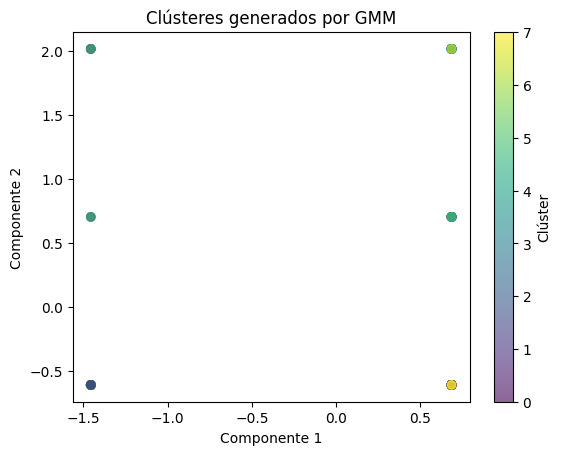

Log-Likelihood: 5.661198773175521
BIC: 7508.173389206043


In [ ]:
# Probamos los métodos realizados anteriormente pero con los datos con las
# variables eliminadas:

X = cuestionario
# Número de clústeres
n_clusters = 8  # Cambia según el número deseado
# Escalado de las variables
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Ajustar el modelo GMM
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm.fit(X)

# Predecir las etiquetas de los clústeres
labels = gmm.predict(X)

# Agregar las etiquetas de los clústeres al DataFrame
cuestionario['cluster'] = labels

# Visualización simple (si tienes 2 componentes principales)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.title("Clústeres generados por GMM")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.colorbar(label="Clúster")
plt.show()
# Log-Likelihood del modelo
print("Log-Likelihood:", gmm.score(X))

# BIC (criterio de información bayesiano)
print("BIC:", gmm.bic(X))

In [ ]:
# Comprobamos de nuevo la varianza del cuestionario y vemos que no ha cambiado
# lo unico que tenemos una nueva variable, llamada cluster, pero que se eliminara
# más adelante
varianzas = cuestionario.var()
print(varianzas.sort_values())

invitados               0.070359
musica_Otros            0.076083
musica_Pop              0.076083
musica_Indie            0.080133
fiestas                 0.081228
horario_semana          0.087023
cocina                  0.088119
lgbt_friendly           0.094062
horario_fin_semana      0.095596
deporte                 0.101250
musica_Urbano           0.103434
lectura                 0.117685
mascotas                0.134555
fumas                   0.145442
fumar_otras_personas    0.147768
3                       0.168790
4                       0.184703
2                       0.205375
compartido_piso         0.218802
genero_Mujer            0.245892
cluster                 4.172958
dtype: float64


In [ ]:
cuestionario.head()

,compartido_piso,fumas,fumar_otras_personas,invitados,mascotas,deporte,lectura,cocina,lgbt_friendly,fiestas,...,horario_fin_semana,2,3,4,genero_Mujer,musica_Indie,musica_Otros,musica_Pop,musica_Urbano,cluster
0,1.0,0.5,0.5,0.5,0.5,1.00,1.00,0.5,0.5,0.5,...,0.5,0,1,0,0,0,0,0,1,1
1,0.0,0.0,0.5,1.0,1.0,0.66,1.00,1.0,1.0,0.5,...,0.5,0,1,0,1,0,0,0,0,3
2,0.0,0.0,0.5,0.5,1.0,1.00,0.33,1.0,0.5,0.5,...,1.0,0,1,0,0,0,0,0,0,6
4,0.0,1.0,0.5,1.0,0.5,1.00,0.33,1.0,0.5,0.5,...,1.0,0,1,0,0,0,0,0,0,6
5,0.0,1.0,0.0,1.0,0.5,1.00,1.00,1.0,0.5,0.5,...,0.5,0,0,1,0,0,0,0,0,6


In [ ]:
# Subimos el limite de varianza que deben tener nuestras variables para seguir
# ya que como no conseguimos que el modelo sea efectivo por la poca varianza
# nos vamos a quedar solo con las que mas tienen, aunque estemos perdiendo gran
# parte de las variables.
varianza_baja = [col for col in cuestionario.var().index if cuestionario[col].var() < 0.1]
cuestionario = cuestionario.drop(columns=varianza_baja)
print(f"Columnas eliminadas por baja varianza: {varianza_baja}")

Columnas eliminadas por baja varianza: ['invitados', 'cocina', 'lgbt_friendly', 'fiestas', 'horario_semana', 'horario_fin_semana', 'musica_Indie', 'musica_Otros', 'musica_Pop']


In [ ]:
# Droppeamos fumas, ya que es redundante con fumar otros y la variable cluster
# que no tiene que estar para k-means
cuestionario = cuestionario.drop(columns=["fumas", "cluster"])

In [ ]:
# Como vemos, el DataFrame ha quedado bastante reducido a 10 columnas,
cuestionario.head()

,compartido_piso,fumar_otras_personas,mascotas,deporte,lectura,2,3,4,genero_Mujer,musica_Urbano
0,1.0,0.5,0.5,1.00,1.00,0,1,0,0,1
1,0.0,0.5,1.0,0.66,1.00,0,1,0,1,0
2,0.0,0.5,1.0,1.00,0.33,0,1,0,0,0
4,0.0,0.5,0.5,1.00,0.33,0,1,0,0,0
5,0.0,0.0,0.5,1.00,1.00,0,0,1,0,0


In [ ]:
# Una de las columnas es de música urbana, no tendría mucho sentido que este
# sin que estén las otras, sin embargo, como puede ayudar a juntar a gente
# que se consideré de esa "tribu urbana" la vamos a dejar

In [ ]:
# Aplicamos otra vez PCA con los cambios realizados
n_componentes = 5
pca = PCA(n_components=n_componentes)
X_pca = pca.fit_transform(cuestionario)

In [ ]:
print("Varianza explicada por cada componente:")
print(pca.explained_variance_ratio_)

print("Varianza acumulada:")
print(pca.explained_variance_ratio_.cumsum())

Varianza explicada por cada componente:
[0.18984333 0.14850598 0.14221016 0.129478   0.10421796]
Varianza acumulada:
[0.18984333 0.33834931 0.48055947 0.61003746 0.71425542]


In [ ]:
# Aplicamos k-means sobre los datos transformados
X = X_pca
rango_clusters = range(2, 18) # Aumentado el rango de los clusters para analizarlo
siluetas = []

for n_clusters in rango_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silueta_promedio = silhouette_score(X, cluster_labels)
    siluetas.append(silueta_promedio)
    print(f"Para {n_clusters} clústeres, el índice de silueta promedio es {silueta_promedio:.3f}")

Para 2 clústeres, el índice de silueta promedio es 0.222
Para 3 clústeres, el índice de silueta promedio es 0.247
Para 4 clústeres, el índice de silueta promedio es 0.242
Para 5 clústeres, el índice de silueta promedio es 0.253
Para 6 clústeres, el índice de silueta promedio es 0.283
Para 7 clústeres, el índice de silueta promedio es 0.310
Para 8 clústeres, el índice de silueta promedio es 0.349
Para 9 clústeres, el índice de silueta promedio es 0.366
Para 10 clústeres, el índice de silueta promedio es 0.370
Para 11 clústeres, el índice de silueta promedio es 0.389
Para 12 clústeres, el índice de silueta promedio es 0.387
Para 13 clústeres, el índice de silueta promedio es 0.381
Para 14 clústeres, el índice de silueta promedio es 0.342
Para 15 clústeres, el índice de silueta promedio es 0.349
Para 16 clústeres, el índice de silueta promedio es 0.353
Para 17 clústeres, el índice de silueta promedio es 0.357


In [ ]:
# Como vemos sigue saliendo muy poco, aunque hemos mejorado mucho el modelo
# respecto al principio (donde casi no superaba el 0.1

In [ ]:
# Vamos probando diferentes componentes del PCA para ver con cuántos obtenemos
# mejores resultados
n_componentes = 3
pca = PCA(n_components=n_componentes)
X_pca = pca.fit_transform(cuestionario)

In [ ]:
print("Varianza explicada por cada componente:")
print(pca.explained_variance_ratio_)

print("Varianza acumulada:")
print(pca.explained_variance_ratio_.cumsum())

Varianza explicada por cada componente:
[0.18984333 0.14850598 0.14221016]
Varianza acumulada:
[0.18984333 0.33834931 0.48055947]


In [ ]:
# Aplicamos k-means para este numero de componentes
X = X_pca
rango_clusters = range(2, 18)
siluetas = []

for n_clusters in rango_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silueta_promedio = silhouette_score(X, cluster_labels)
    siluetas.append(silueta_promedio)
    print(f"Para {n_clusters} clústeres, el índice de silueta promedio es {silueta_promedio:.3f}")

Para 2 clústeres, el índice de silueta promedio es 0.363
Para 3 clústeres, el índice de silueta promedio es 0.374
Para 4 clústeres, el índice de silueta promedio es 0.420
Para 5 clústeres, el índice de silueta promedio es 0.410
Para 6 clústeres, el índice de silueta promedio es 0.442
Para 7 clústeres, el índice de silueta promedio es 0.458
Para 8 clústeres, el índice de silueta promedio es 0.466
Para 9 clústeres, el índice de silueta promedio es 0.477
Para 10 clústeres, el índice de silueta promedio es 0.485
Para 11 clústeres, el índice de silueta promedio es 0.478
Para 12 clústeres, el índice de silueta promedio es 0.490
Para 13 clústeres, el índice de silueta promedio es 0.506
Para 14 clústeres, el índice de silueta promedio es 0.502
Para 15 clústeres, el índice de silueta promedio es 0.513
Para 16 clústeres, el índice de silueta promedio es 0.523
Para 17 clústeres, el índice de silueta promedio es 0.462


In [ ]:
# Como vemos, aquí el indice de silueta aumenta considerablemente llegando incluso
# por encima de 0.5 con 16 clusters. Conseguimos una mejora muy significativa
# respecto al inicio (<0.1). Sin embargo debemos tener cuidado con la interpretación
# de los resultados, ya que la varianza acumulada con 3 componentes del PCA era
# solo de 48%, por lo que hay gran parte de la información que nos estamos
# perdiendo, además de las variables que hemos quitado. Ahora debemos elegir
# cual es el numero de clusters con el que mejor funciona el modelo. Para ello
# vamos a usar estadisticos y visalizaciones como el metodo del codo y
# graficos de dispersión

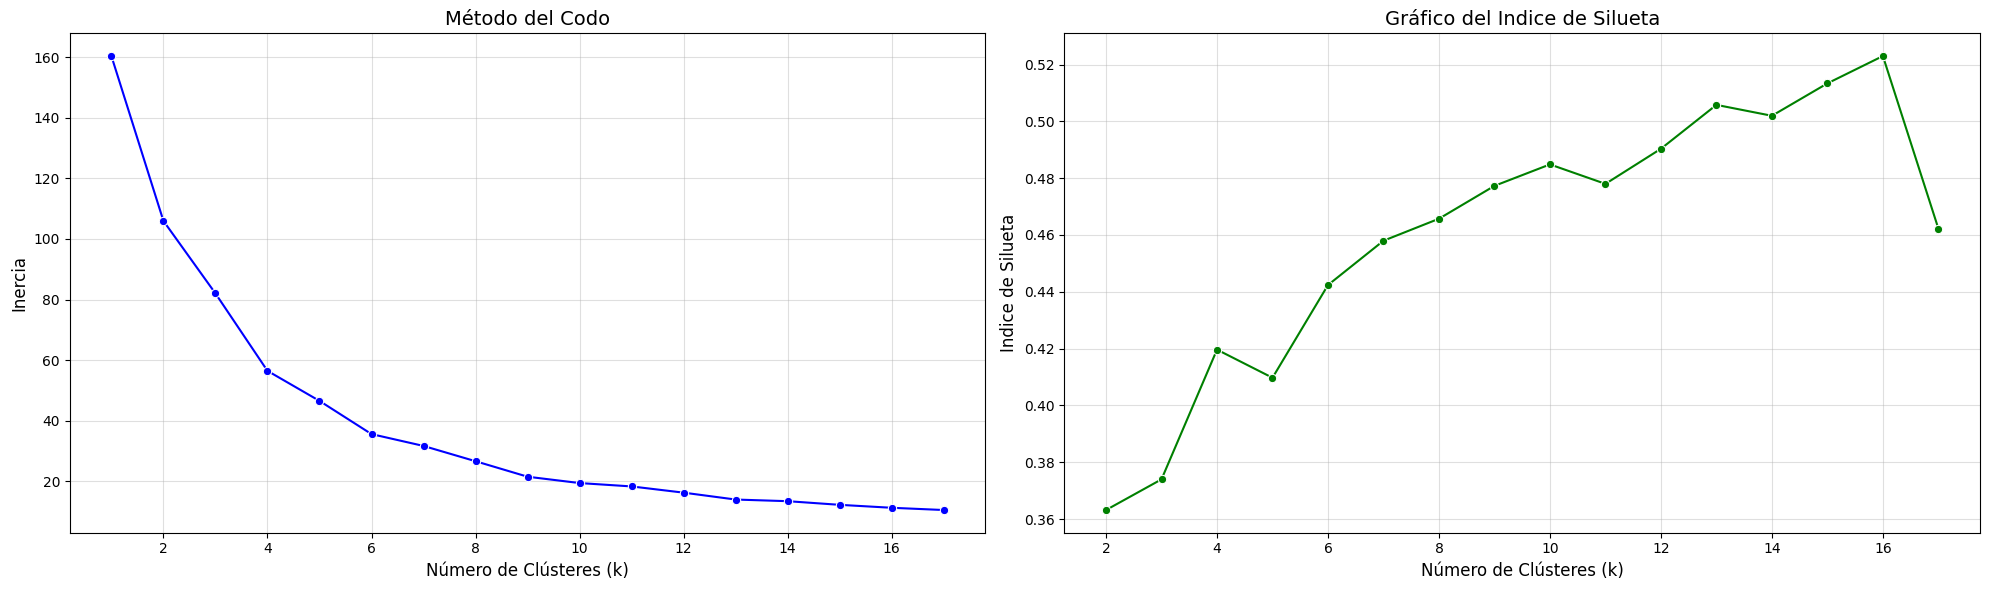

In [ ]:
# Establecemos los parámetros
sse = {}
sil = []
kmax = 17

# Gráficos subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Metodo del codo
plt.subplot(1, 2, 1)
for k in range(1, kmax + 1):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=42).fit(X)
    sse[k] = kmeans.inertia_

sns.lineplot(x=list(sse.keys()), y=list(sse.values()), ax=axes[0], marker="o", color="blue")
axes[0].set_title("Método del Codo", fontsize=14)
axes[0].set_xlabel("Número de Clústeres (k)", fontsize=12)
axes[0].set_ylabel("Inercia", fontsize=12)
axes[0].grid(alpha=0.4)

# Indice de silueta
plt.subplot(1, 2, 2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    labels = kmeans.labels_
    sil.append(silhouette_score(X, labels, metric='euclidean'))

sns.lineplot(x=range(2, kmax + 1), y=sil, ax=axes[1], marker="o", color="green")
axes[1].set_title("Gráfico del Indice de Silueta", fontsize=14)
axes[1].set_xlabel("Número de Clústeres (k)", fontsize=12)
axes[1].set_ylabel("Indice de Silueta", fontsize=12)
axes[1].grid(alpha=0.4)

plt.tight_layout()
plt.show()

In [ ]:
# Como vemos, no tenemos un codo muy marcado, aunque nos parece indicar que el
# numero de clusters más correcto sería de 4. Donde el indice de silueta es de
# 0.420.

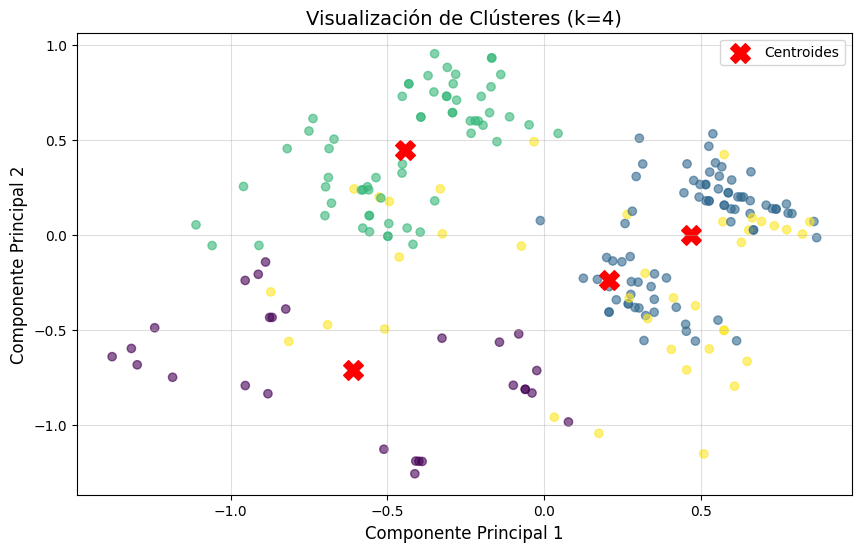

In [ ]:
# Para visualizar cómo clusteriza el modelo usamos un gráfico de dispersión
n_clusters_visual = 4
kmeans = KMeans(n_clusters=n_clusters_visual, random_state=42)
labels = kmeans.fit_predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroides')
plt.title(f"Visualización de Clústeres (k={n_clusters_visual})", fontsize=14)
plt.xlabel("Componente Principal 1", fontsize=12)
plt.ylabel("Componente Principal 2", fontsize=12)
plt.legend()
plt.grid(alpha=0.4)
plt.show()


In [ ]:
# Vemos que tenemos 2 clusters muy marcados (azul y verde) pero otros 2
# muy dispersos (amarillo y morado)

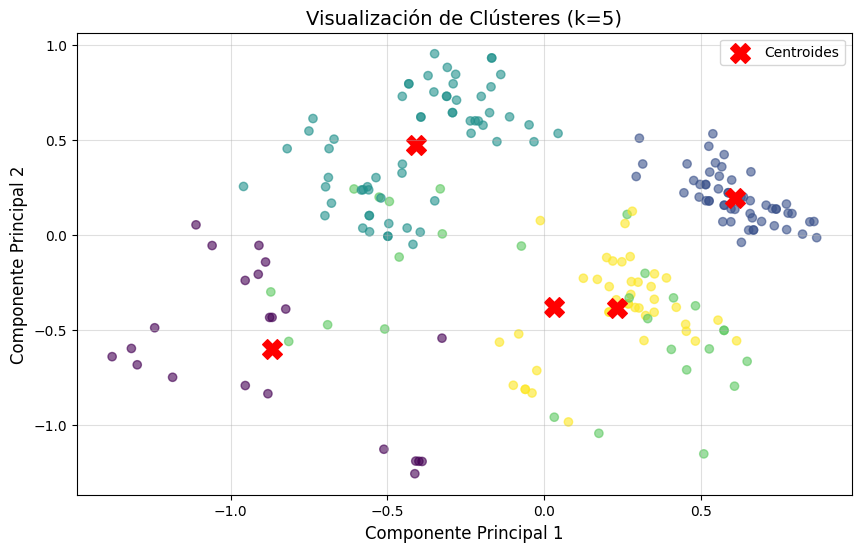

In [ ]:
# Vemos cómo queda con otro número de clusters
n_clusters_visual = 5
kmeans = KMeans(n_clusters=n_clusters_visual, random_state=42)
labels = kmeans.fit_predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroides')
plt.title(f"Visualización de Clústeres (k={n_clusters_visual})", fontsize=14)
plt.xlabel("Componente Principal 1", fontsize=12)
plt.ylabel("Componente Principal 2", fontsize=12)
plt.legend()
plt.grid(alpha=0.4)
plt.show()


In [ ]:
# Vemos que que se puede diferenciar mejor los diferentes grupos
# a excepción del cluster representado por el color verde, que está muy disperso

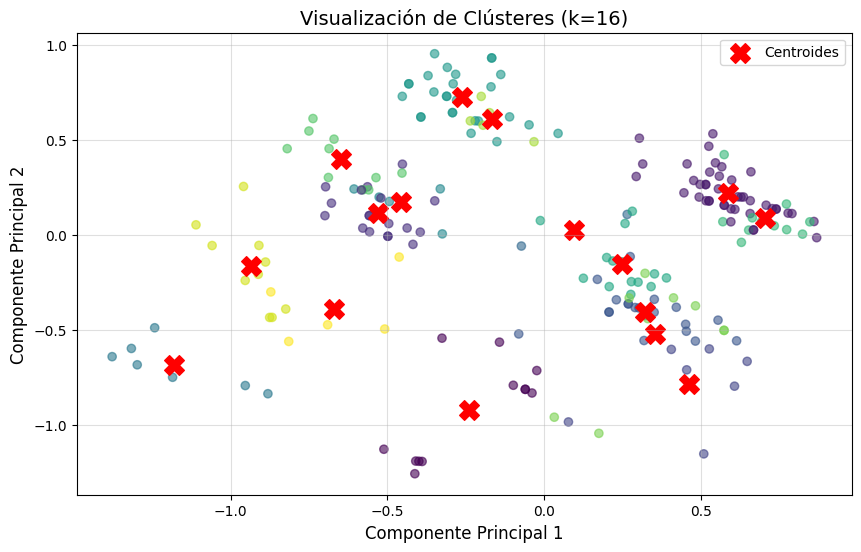

In [ ]:
# Vemos cómo queda con el máximo indice de silueta, que son 16 clusters
n_clusters_visual = 16
kmeans = KMeans(n_clusters=n_clusters_visual, random_state=42)
labels = kmeans.fit_predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroides')
plt.title(f"Visualización de Clústeres (k={n_clusters_visual})", fontsize=14)
plt.xlabel("Componente Principal 1", fontsize=12)
plt.ylabel("Componente Principal 2", fontsize=12)
plt.legend()
plt.grid(alpha=0.4)
plt.show()


In [ ]:
# Son demasiados clusters, pese a que el Indice de Silueta pueda ser mayor,
# realmente es una clusterización peor que con 4 o 5 clusters

Tras realizar varias preubas, se consiguio subir la varainza del modelo de 0.1 hasta niveles de 0.4 y 0.5. La mejora es significativa, aunque tuvimos que quitar muchas variables y no son los resultados esperados. Antes de realizar estos cambios, se trataron de hacer cambios en el preprocesamiento y tratamiento de varias variables para aumentar la varianza dadas las distribuciones que teniamos en las variables numéricas (muy sesgadas y respuestas acumuladas). Quité variables con correlaciones moderadas como ruido_dia y ruido_noche (correlación de 0.5) para disminuir la redundancia. Encontre en kaggle que recomendaban aplicar transformación logaritmica para las variables sesgadas como la limpieza, ruido, etc. Con ningun metodo consegui aumentar el indice de silueta del modelo. A partir de juntar variables con una varianza baja que tuvieran que ver entre ellas, cree nuevas variables como Sociabilidad, Hogar, Hobbies... Cuando pensaba que esta técnica me habia funcionado, realmente no fue así, su varianza era mayor porque al sumar los diferentes coeficientes de cada variable el rango habia aumentado, pero cuando lo normalice su varianza era muy muy baja, incluso menor que las variables originales.
Todos estos procesos no se han puesto ya que hacian que el notebook estuviera muy desordenado y con pasos que luego no eran implementado. Sin embargo lo señalo aqui para dejar constancia y preguntar por qué otros métodos podría aplicar para mejorar el modelo cuando me encuentre con conjuntos de datos así.
Gracias.